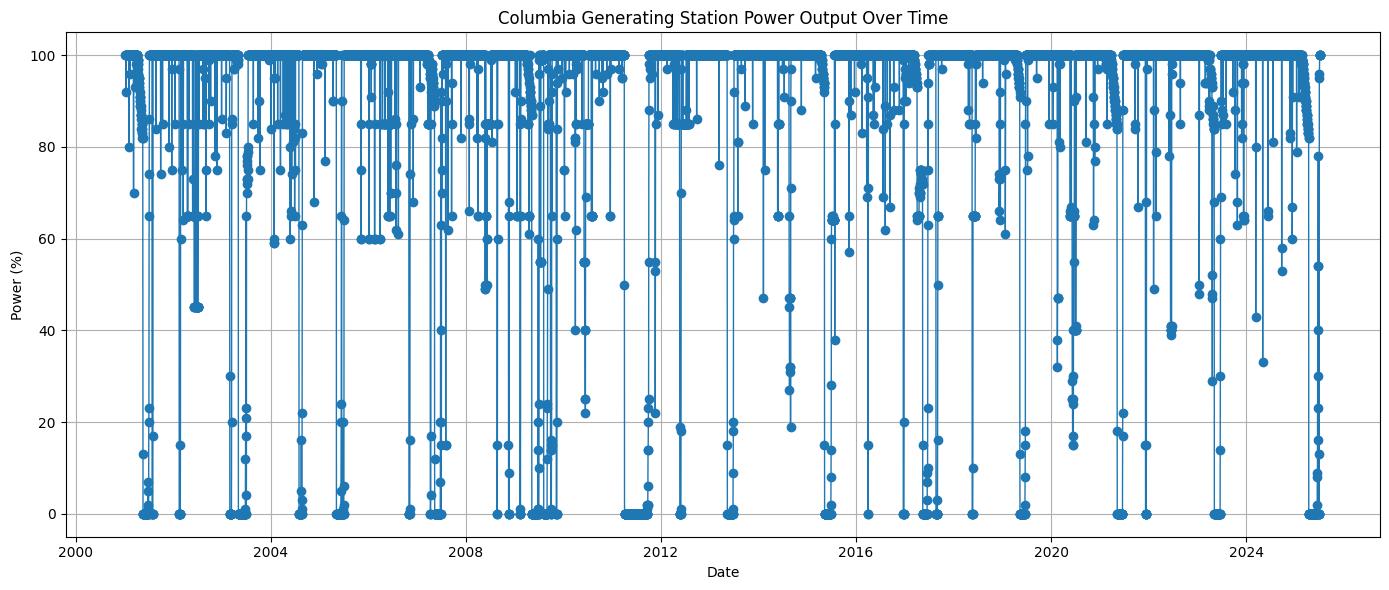

In [1]:
import os
import django
import pandas as pd
import matplotlib.pyplot as plt
from threading import Thread
from queue import Queue

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "nucleartimeseries_api.settings")
django.setup()

from nrc_data.models import ReactorStatus

# Threaded function to fetch data
def get_data_thread(q):
    qs = ReactorStatus.objects.filter(unit__icontains="Columbia Generating Station").order_by('report_date')
    q.put(list(qs.values("report_date", "power")))

# Use thread to execute ORM
q = Queue()
t = Thread(target=get_data_thread, args=(q,))
t.start()
t.join()
data = q.get()

# Plot
df = pd.DataFrame(data)
plt.figure(figsize=(14, 6))
plt.plot(df["report_date"], df["power"], marker="o", linestyle="-", linewidth=1)
plt.title("Columbia Generating Station Power Output Over Time")
plt.xlabel("Date")
plt.ylabel("Power (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import plotly.express as px

# Convert to DataFrame (already done above)
df = pd.DataFrame(data)

# Plot with Plotly
fig = px.line(
    df,
    x="report_date",
    y="power",
    title="Columbia Generating Station Power Output Over Time"
)

# Add zoom and horizontal scroll
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis_title="Power (%)",
    xaxis_title="Date"
)

fig.show()


In [3]:
from prophet import Prophet
import pandas as pd
import plotly.graph_objects as go

# Convert to DataFrame
df = pd.DataFrame(data)

# Rename for Prophet
df_prophet = df.rename(columns={
    "report_date": "ds",
    "power": "y"
})

# STEP 1: Identify refueling outages (power == 0, optional 'reason' if available)
# If you have a 'reason' field with "refueling", use that instead.
refuel_days = df_prophet[df_prophet["y"] == 0]

# STEP 2: Create holidays DataFrame
holidays = pd.DataFrame({
    "holiday": "refueling_outage",
    "ds": refuel_days["ds"],
    "lower_window": 0,
    "upper_window": 5  # assume outages may affect 5 days around the drop
})

# STEP 3: Initialize Prophet with holidays
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.5,
    holidays=holidays
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)


# STEP 4: Fit model
model.fit(df_prophet)

# STEP 5: Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


/home/ballaprr/Documents/NuclearTimeSeries/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

02:38:01 - cmdstanpy - INFO - Chain [1] start processing
02:38:02 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], mode='lines', name='Actual Power Output'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecasted Power Output'))

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(width=0), name='Upper Bound', showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', fill='tonexty', line=dict(width=1), name='Lower Bound', showlegend=False))


fig.update_layout(
    title="Columbia Generating Station Power Forecast",
    xaxis_title="Date",
    yaxis_title="Power (%)",
    xaxis=dict(rangeslider=dict(visible=True), type="date"),
    template="plotly_white"
)

fig.show()

In [5]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

  0%|          | 0/42 [00:00<?, ?it/s]02:38:15 - cmdstanpy - INFO - Chain [1] start processing
02:38:15 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/42 [00:00<00:19,  2.07it/s]02:38:16 - cmdstanpy - INFO - Chain [1] start processing
02:38:16 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/42 [00:01<00:20,  1.92it/s]02:38:16 - cmdstanpy - INFO - Chain [1] start processing
02:38:16 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/42 [00:01<00:20,  1.94it/s]02:38:17 - cmdstanpy - INFO - Chain [1] start processing
02:38:17 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 4/42 [00:02<00:20,  1.86it/s]02:38:17 - cmdstanpy - INFO - Chain [1] start processing
02:38:17 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 5/42 [00:02<00:20,  1.81it/s]02:38:18 - cmdstanpy - INFO - Chain [1] start processing
02:38:18 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 6/42 [00:03<00:20,  1.76it/s]02:38:18

  horizon         mse       rmse       mae     mdape     smape  coverage
0 37 days  147.614961  12.149690  5.466071  0.031224  0.159698  0.943864
1 38 days  146.586930  12.107309  5.487950  0.031629  0.162787  0.943243
2 39 days  142.369108  11.931853  5.456030  0.031953  0.164694  0.943895
3 40 days  139.514733  11.811635  5.440069  0.031989  0.166018  0.944890
4 41 days  135.710720  11.649494  5.395310  0.032231  0.166433  0.946506


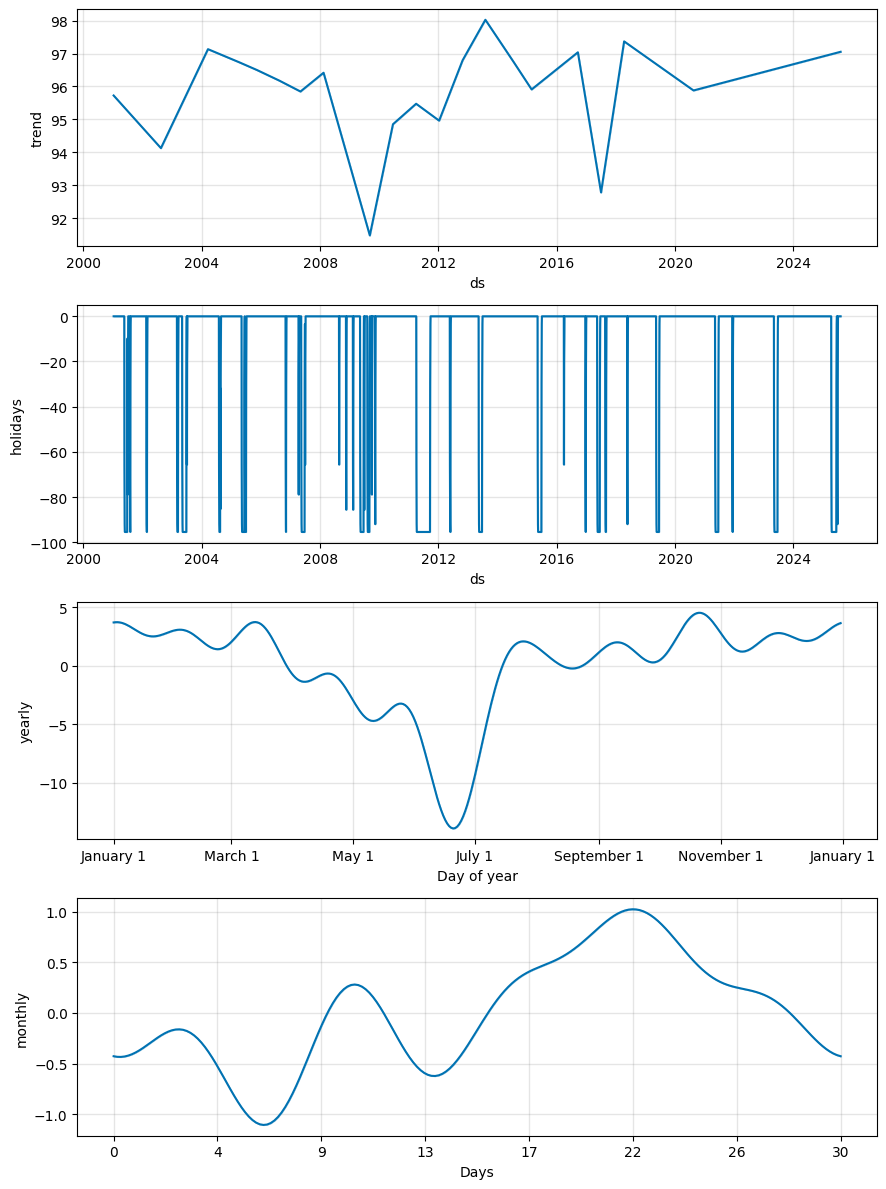

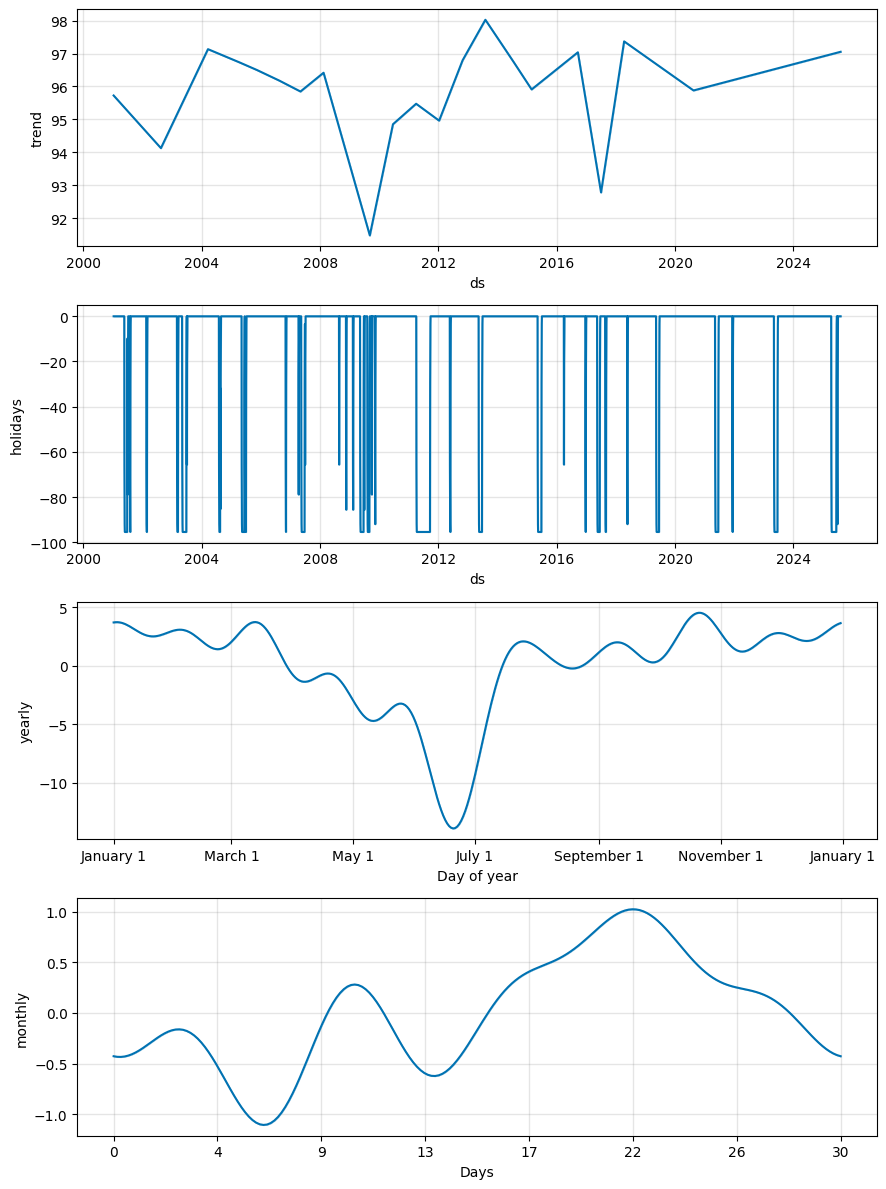

In [6]:
model.plot_components(forecast)


In [7]:
future = model.make_future_dataframe(periods=30)
future


ds
0    2001-01-08
1    2001-01-09
2    2001-01-10
3    2001-01-11
4    2001-01-12
...         ...
8949 2025-08-02
8950 2025-08-03
8951 2025-08-04
8952 2025-08-05
8953 2025-08-06

[8954 rows x 1 columns]

In [8]:
print(forecast[['ds']].tail())
print("Latest date in original data:", df_prophet['ds'].max())


             ds
8949 2025-08-02
8950 2025-08-03
8951 2025-08-04
8952 2025-08-05
8953 2025-08-06
Latest date in original data: 2025-07-07


In [9]:
latest_date = pd.to_datetime('2025-07-03')
next_day = latest_date + pd.Timedelta(days=1)
next_day_forecast = forecast[forecast['ds'] == next_day]
print(next_day_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


             ds       yhat  yhat_lower  yhat_upper
8920 2025-07-04  90.333996   76.844606   104.64645


03:33:04 - cmdstanpy - INFO - Chain [1] start processing
03:33:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/42 [00:00<?, ?it/s]03:33:07 - cmdstanpy - INFO - Chain [1] start processing
03:33:07 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/42 [00:00<00:18,  2.24it/s]03:33:08 - cmdstanpy - INFO - Chain [1] start processing
03:33:08 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/42 [00:00<00:19,  2.04it/s]03:33:08 - cmdstanpy - INFO - Chain [1] start processing
03:33:08 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/42 [00:01<00:19,  2.01it/s]03:33:09 - cmdstanpy - INFO - Chain [1] start processing
03:33:09 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 4/42 [00:02<00:20,  1.90it/s]03:33:09 - cmdstanpy - INFO - Chain [1] start processing
03:33:09 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 5/42 [00:02<00:20,  1.84it/s]03:33:10 - cmdstanpy - INFO - Chain [1] start processing
03:33:10 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 6/42 [00:03<00:20,  1.79it/s]03:33:10

  horizon         mse       rmse       mae     mdape     smape  coverage
0 37 days  147.614961  12.149690  5.466071  0.031224  0.159698  0.943864
1 38 days  146.586930  12.107309  5.487950  0.031629  0.162787  0.943243
2 39 days  142.369108  11.931853  5.456030  0.031953  0.164694  0.943895
3 40 days  139.514733  11.811635  5.440069  0.031989  0.166018  0.944890
4 41 days  135.710720  11.649494  5.395310  0.032231  0.166433  0.946506


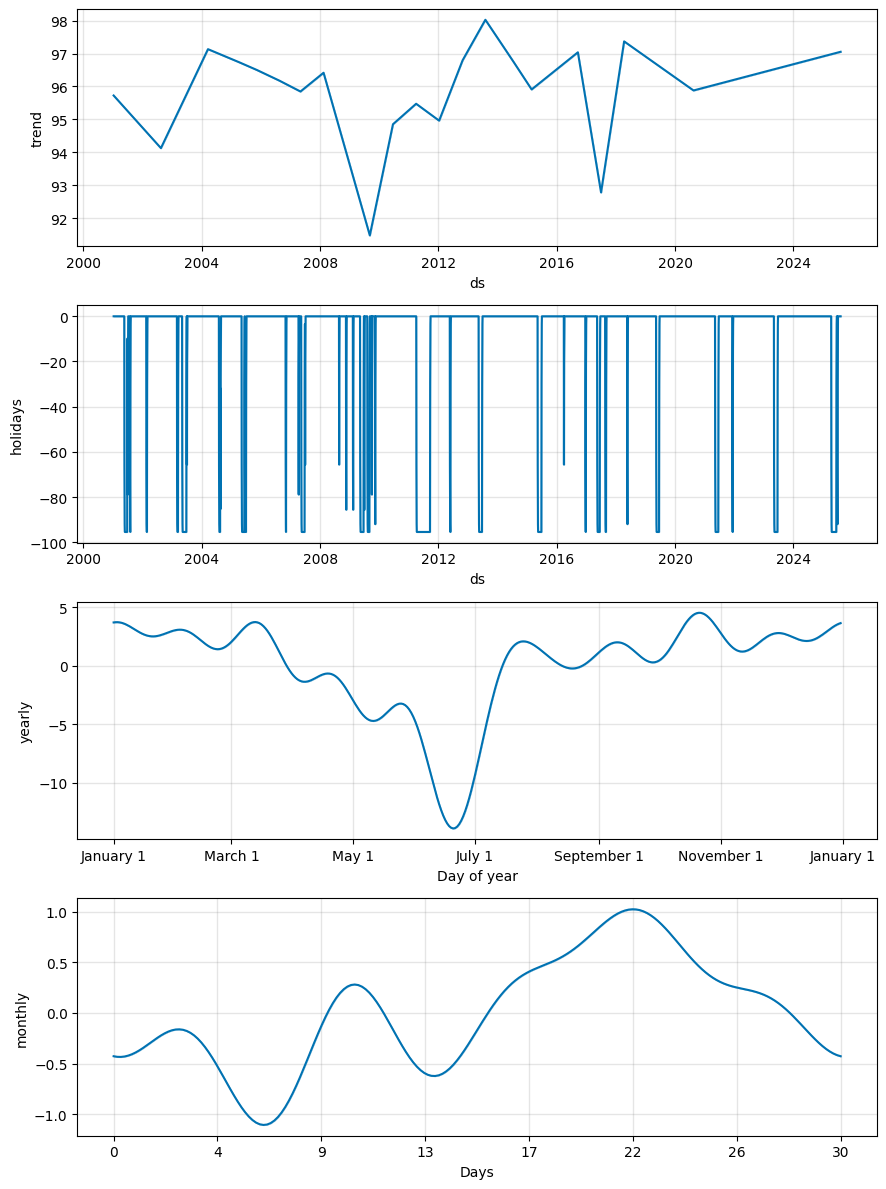

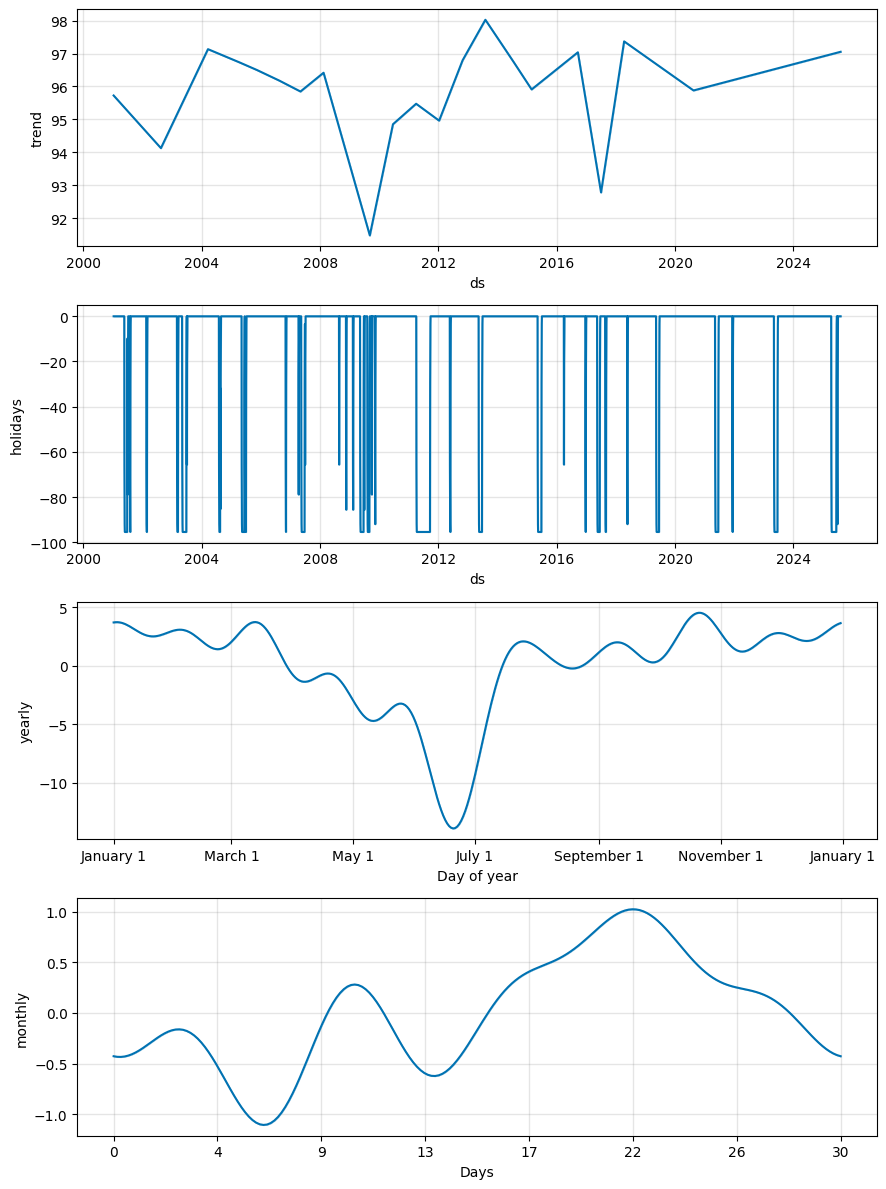

In [13]:
import os
import django
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from threading import Thread
from queue import Queue

# Setup Django environment
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "nucleartimeseries_api.settings")
django.setup()

from nrc_data.models import ReactorStatus

# Fetch data using a thread
def get_data_thread(q):
    qs = ReactorStatus.objects.filter(unit__icontains="Columbia Generating Station").order_by("report_date")
    q.put(list(qs.values("report_date", "power")))

q = Queue()
t = Thread(target=get_data_thread, args=(q,))
t.start()
t.join()
data = q.get()

# Convert to DataFrame
df = pd.DataFrame(data)
df_prophet = df.rename(columns={"report_date": "ds", "power": "y"})

# Plot original time series
fig = px.line(df, x="report_date", y="power", title="Columbia Generating Station Power Output Over Time")
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="date"), yaxis_title="Power (%)", xaxis_title="Date")
fig.show()

# Refueling outages
refuel_days = df_prophet[df_prophet["y"] == 0]
holidays = pd.DataFrame({
    "holiday": "refueling_outage",
    "ds": refuel_days["ds"],
    "lower_window": 0,
    "upper_window": 5
})

# Prophet model setup
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.5,
    holidays=holidays
)
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)
model.fit(df_prophet)

# Predict next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Forecast vs actual
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], mode='lines', name='Actual Power Output'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecasted Power Output'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(width=0), name='Upper Bound', showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', fill='tonexty', line=dict(width=1), name='Lower Bound', showlegend=False))
fig.update_layout(title="Columbia Generating Station Power Forecast", xaxis_title="Date", yaxis_title="Power (%)", template="plotly_white")
fig.show()

# 30-day forecast only
latest_ds = pd.to_datetime(df_prophet['ds'].max())
forecast_only = forecast[forecast['ds'] > latest_ds]
fig_30 = px.line(forecast_only, x='ds', y='yhat', title='Next 30-Day Power Forecast')
fig_30.update_layout(xaxis_title="Date", yaxis_title="Forecasted Power (%)")
fig_30.show()

# Optional: model diagnostics
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Component plots (trend + seasonal)
model.plot_components(forecast)


In [12]:
import os
import django
import pandas as pd
from threading import Thread
from queue import Queue
from prophet import Prophet
import plotly.graph_objects as go
from prophet.diagnostics import cross_validation, performance_metrics
from datetime import timedelta

# Django setup
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "nucleartimeseries_api.settings")
django.setup()

from nrc_data.models import ReactorStatus

# Fetch data from DB
def get_data_thread(q):
    qs = ReactorStatus.objects.filter(unit__icontains="Columbia Generating Station").order_by('report_date')
    q.put(list(qs.values("report_date", "power")))

q = Queue()
t = Thread(target=get_data_thread, args=(q,))
t.start()
t.join()
data = q.get()

# Prepare DataFrame
df = pd.DataFrame(data)
df_prophet = df.rename(columns={"report_date": "ds", "power": "y"})

# Identify refueling outages
refuel_days = df_prophet[df_prophet["y"] == 0]
holidays = pd.DataFrame({
    "holiday": "refueling_outage",
    "ds": refuel_days["ds"],
    "lower_window": 0,
    "upper_window": 5
})

# Train model
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.5,
    holidays=holidays
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)

# Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

print("Evaluating model accuracy...")
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')
df_metrics = performance_metrics(df_cv)
print(df_metrics.columns)
print(df_metrics[['horizon', 'mae', 'rmse', 'mdape']].head())


# Keep only the 30-day forecast portion
latest_date = pd.to_datetime(df_prophet['ds'].max())
forecast_30 = forecast[forecast['ds'] > latest_date]

latest_actual_date = df_prophet['ds'].max()

next_day = pd.to_datetime(latest_actual_date + timedelta(days=1))
thirtieth_day = pd.to_datetime(latest_actual_date + timedelta(days=30))

next_day_forecast = forecast[forecast['ds'] == next_day]
day30_forecast = forecast[forecast['ds'] == thirtieth_day]

print("\n📅 Next Day Forecast:")
print(next_day_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
print("\n📅 30th Day Forecast:")
print(day30_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plot: Actual and 30-Day Forecast
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], mode='lines', name='Actual Power Output'))

# Forecasted data
fig.add_trace(go.Scatter(x=forecast_30['ds'], y=forecast_30['yhat'], mode='lines', name='Forecasted Power Output'))

# Confidence interval
fig.add_trace(go.Scatter(x=forecast_30['ds'], y=forecast_30['yhat_upper'], mode='lines', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast_30['ds'], y=forecast_30['yhat_lower'], mode='lines', fill='tonexty', line=dict(width=1), showlegend=False))

fig.update_layout(
    title="Columbia Generating Station – Next 30 Day Forecast vs Actual",
    xaxis_title="Date",
    yaxis_title="Power (%)",
    xaxis=dict(rangeslider=dict(visible=True), type="date"),
    template="plotly_white"
)

fig.write_image('fig1.png', engine='orca')

fig.show()





00:14:05 - cmdstanpy - INFO - Chain [1] start processing
00:14:07 - cmdstanpy - INFO - Chain [1] done processing


Evaluating model accuracy...


  0%|          | 0/42 [00:00<?, ?it/s]00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/42 [00:00<00:19,  2.13it/s]00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/42 [00:00<00:18,  2.11it/s]00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/42 [00:01<00:19,  1.95it/s]00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 4/42 [00:02<00:20,  1.87it/s]00:14:10 - cmdstanpy - INFO - Chain [1] start processing
00:14:10 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 5/42 [00:02<00:20,  1.84it/s]00:14:10 - cmdstanpy - INFO - Chain [1] start processing
00:14:11 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 6/42 [00:03<00:20,  1.78it/s]00:14:11

Index(['horizon', 'mse', 'rmse', 'mae', 'mdape', 'smape', 'coverage'], dtype='object')
  horizon       mae       rmse     mdape
0 37 days  5.475523  12.098115  0.031458
1 38 days  5.443907  11.922746  0.031529
2 39 days  5.428271  11.802562  0.031658
3 40 days  5.383852  11.640403  0.031783
4 41 days  5.366764  11.535857  0.032084

📅 Next Day Forecast:
             ds       yhat  yhat_lower  yhat_upper
8925 2025-07-09  93.392347   78.706628  107.369708

📅 30th Day Forecast:
             ds       yhat  yhat_lower  yhat_upper
8954 2025-08-07  97.692808   83.858837  113.447877



/tmp/ipykernel_2414175/3468734939.py:101: DeprecationWarning:


Support for the Orca engine is deprecated and will be removed after September 2025.
Please install Kaleido (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`) to use the Kaleido engine.


/tmp/ipykernel_2414175/3468734939.py:101: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




ValueError: 
The plotly.io.orca.config.use_xvfb property is set to True, but the
xvfb-run executable could not be found on the system path.

Searched for the executable 'xvfb-run' on the following path:
    /home/ballaprr/Documents/NuclearTimeSeries/env/bin
    /home/ballaprr/.local/bin
    /home/ballaprr/.local/bin
    /home/ballaprr/Android/Sdk/emulator
    /home/ballaprr/Android/Sdk/tools
    /home/ballaprr/Android/Sdk/tools/bin
    /home/ballaprr/Android/Sdk/platform-tools
    /usr/lib/jvm/java-17-openjdk-amd64/bin
    /tmp/.mount_cursorG0DjE1/usr/bin
    /tmp/.mount_cursorG0DjE1/usr/sbin
    /tmp/.mount_cursorG0DjE1/usr/games
    /tmp/.mount_cursorG0DjE1/bin
    /tmp/.mount_cursorG0DjE1/sbin
    /home/ballaprr/.local/bin
    /home/ballaprr/Android/Sdk/emulator
    /home/ballaprr/Android/Sdk/tools
    /home/ballaprr/Android/Sdk/tools/bin
    /home/ballaprr/Android/Sdk/platform-tools
    /usr/lib/jvm/java-17-openjdk-amd64/bin
    /home/ballaprr/anaconda3/bin
    /home/ballaprr/anaconda3/condabin
    /home/ballaprr/.local/bin
    /usr/local/sbin
    /usr/local/bin
    /usr/sbin
    /usr/bin
    /sbin
    /bin
    /usr/games
    /usr/local/games
    /snap/bin
    /snap/bin

In [11]:
import plotly.io as pio
fig.write_image('fig1.png', engine='orca')

/tmp/ipykernel_2414175/1058254196.py:2: DeprecationWarning:


Support for the Orca engine is deprecated and will be removed after September 2025.
Please install Kaleido (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`) to use the Kaleido engine.


/tmp/ipykernel_2414175/1058254196.py:2: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




ValueError: 
The plotly.io.orca.config.use_xvfb property is set to True, but the
xvfb-run executable could not be found on the system path.

Searched for the executable 'xvfb-run' on the following path:
    /home/ballaprr/Documents/NuclearTimeSeries/env/bin
    /home/ballaprr/.local/bin
    /home/ballaprr/.local/bin
    /home/ballaprr/Android/Sdk/emulator
    /home/ballaprr/Android/Sdk/tools
    /home/ballaprr/Android/Sdk/tools/bin
    /home/ballaprr/Android/Sdk/platform-tools
    /usr/lib/jvm/java-17-openjdk-amd64/bin
    /tmp/.mount_cursorG0DjE1/usr/bin
    /tmp/.mount_cursorG0DjE1/usr/sbin
    /tmp/.mount_cursorG0DjE1/usr/games
    /tmp/.mount_cursorG0DjE1/bin
    /tmp/.mount_cursorG0DjE1/sbin
    /home/ballaprr/.local/bin
    /home/ballaprr/Android/Sdk/emulator
    /home/ballaprr/Android/Sdk/tools
    /home/ballaprr/Android/Sdk/tools/bin
    /home/ballaprr/Android/Sdk/platform-tools
    /usr/lib/jvm/java-17-openjdk-amd64/bin
    /home/ballaprr/anaconda3/bin
    /home/ballaprr/anaconda3/condabin
    /home/ballaprr/.local/bin
    /usr/local/sbin
    /usr/local/bin
    /usr/sbin
    /usr/bin
    /sbin
    /bin
    /usr/games
    /usr/local/games
    /snap/bin
    /snap/bin

In [21]:
next_day = latest_date + pd.Timedelta(days=1)
predicted = forecast[forecast['ds'] == next_day].iloc[0]
print(predicted)

actual_entry = ReactorStatus.objects.filter(unit='Columbia Generating Station', report_date=next_day).first()
print(actual_entry)

if actual_entry and actual_entry.power is not None:
    if actual_entry.power < predicted['yhat'] * 0.7:
        StubOutage.objects.get_or_create(
            reactor=reactor,
            date_detected=next_day,
            defaults={
                "description": "Auto-detected stub outage",
                "auto_detected": True
            }
        )

if actual_entry.power >= predicted['yhat'] * 0.9:
    StubOutage.objects.filter(
        reactor=reactor, date_detected=next_day, auto_detected=True
    ).delete()

ds                            2025-07-08 00:00:00
trend                                   99.285612
yhat_lower                              90.271498
yhat_upper                             111.625989
trend_lower                             99.285612
trend_upper                             99.285612
additive_terms                           1.648324
additive_terms_lower                     1.648324
additive_terms_upper                     1.648324
holidays                                      0.0
holidays_lower                                0.0
holidays_upper                                0.0
monthly                                  0.101149
monthly_lower                            0.101149
monthly_upper                            0.101149
refueling_outage                              0.0
refueling_outage_lower                        0.0
refueling_outage_upper                        0.0
yearly                                   1.547174
yearly_lower                             1.547174


SynchronousOnlyOperation: You cannot call this from an async context - use a thread or sync_to_async.

In [16]:
# Django setup
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "nucleartimeseries_api.settings")
django.setup()

from nrc_data.models import ReactorStatus

# Fetch data from DB
def get_data_thread(q):
    qs = ReactorStatus.objects.filter(unit__icontains="Arkansas Nuclear 1").order_by('report_date')
    q.put(list(qs.values("report_date", "power")))

q = Queue()
t = Thread(target=get_data_thread, args=(q,))
t.start()
t.join()
data = q.get()

# Prepare DataFrame
df = pd.DataFrame(data)
df_prophet = df.rename(columns={"report_date": "ds", "power": "y"})

# Identify refueling outages
refuel_days = df_prophet[df_prophet["y"] == 0]
holidays = pd.DataFrame({
    "holiday": "refueling_outage",
    "ds": refuel_days["ds"],
    "lower_window": 0,
    "upper_window": 5
})

# Train model
model = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.5,
    holidays=holidays
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)

# Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Keep only the 30-day forecast portion
latest_date = pd.to_datetime(df_prophet['ds'].max())
forecast_30 = forecast[forecast['ds'] > latest_date]

# Plot: Actual and 30-Day Forecast
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], mode='lines', name='Actual Power Output'))

# Forecasted data
fig.add_trace(go.Scatter(x=forecast_30['ds'], y=forecast_30['yhat'], mode='lines', name='Forecasted Power Output'))

# Confidence interval
fig.add_trace(go.Scatter(x=forecast_30['ds'], y=forecast_30['yhat_upper'], mode='lines', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast_30['ds'], y=forecast_30['yhat_lower'], mode='lines', fill='tonexty', line=dict(width=1), showlegend=False))

fig.update_layout(
    title="Arkansas Nuclear 1 – Next 30 Day Forecast vs Actual",
    xaxis_title="Date",
    yaxis_title="Power (%)",
    xaxis=dict(rangeslider=dict(visible=True), type="date"),
    template="plotly_white"
)

fig.show()

05:25:56 - cmdstanpy - INFO - Chain [1] start processing
05:25:58 - cmdstanpy - INFO - Chain [1] done processing
